# CSPB 3202 - Final Project 

## Reinforcement Learning - Lunar Lander

### Table of Contents

1. Overview
2. Approach
3. Results
4. Conclusion
5. References

### Overview

In this project I'm going to be creating an agent to control the Lunar Lander Box2D environment from Gymnasium. The Lunar Lander environment can be referenced here: 

https://gymnasium.farama.org/environments/box2d/lunar_lander/

To begin I will implement a random agent to control the Lunar Lander. Then I will implement a heruistic agent. Finally I will implement a reinforcement learning model. 

#### Lunar Lander Environment Description

**Objective**

The objective of the Lunar Landar Environment is to land between the flags. 

**Action Space**

There are 4 actions that can be taken:

* 0: Do Nothing
* 1: Fire Left Engine
* 2: Fire Main Engine
* 3: Fire Right Engine

**Obervables**

Example obervable:

```Box([ -2.5 -2.5 -10. -10. -6.2831855 -10. -0. -0. ], [ 2.5 2.5 10. 10. 6.2831855 10. 1. 1. ], (8,), float32)```

Decoded values:
|Definition|Value|
|:---------|:----|
|x coordinate|-2.5|
|y coordinate|-2.5|
|x linear velocity|-10|
|y linear velocity|-10|
|angle|-6.2831855|
|angular velocity|-10|
|leg one touchdown|0|
|leg two touchdown|0|

**Reward Criteria**

Each step the following items impact the reward.

- Distance from landing pad
- Movement speed
- Lander tilt
- Contact of each leg
- Number of times the engines are fired
- Landing safely

The total reward is the sum of all the rewards for all steps in the episode. OpenAI states that an episode is considered a solution of it scores at least 200 points. 

**Termination Criteria**

The episode is terminated if the lander crashes, it gets outside the viewpoint, or it's not active.


### Approach

To begin I'm going to start with the random agent. This will allow me to get my environment set up and have a good starting point for this project.

My project is organized as the following:

|File/Folder|Purpose|
|:---------|:----|
|franco_final_project.ipynb|A jupyter notebook containing my final project deliverables|
|scripts|A folder containing python scripts I have created|
|utils|A folder containing useful utilities I've created to assist with this assignemnt|
|ai_env.yml|An export of my conda environment. It can be imported on different machines. See README|
|assignment_definition|A folder containing project details given to us by the professor|
|gym_demos|A folder containing demos from the openAI gym website|

I try to maintain all the python scripts in the code blocks in the scripts directory. I thought it would make it easier for version control of indiviual scripts. They can be viewed and run reparetly there.

#### Random Agent




Running 10 episodes...
Saving vides to: videos/lunarLander_random

Episode 1: 64 steps, reward = -67.53809034789765, success: False 
Episode 2: 63 steps, reward = -102.25786741740913, success: False 
Episode 3: 63 steps, reward = -125.81989746726681, success: False 
Episode 4: 95 steps, reward = -232.38488964427177, success: False 
Episode 5: 107 steps, reward = -284.55950642633684, success: False 
Episode 6: 114 steps, reward = -62.12528964405072, success: False 
Episode 7: 80 steps, reward = -267.1110956527798, success: False 
Episode 8: 105 steps, reward = -282.49806115095924, success: False 
Episode 9: 86 steps, reward = -123.6732767867283, success: False 
Episode 10: 102 steps, reward = -87.86402585837507, success: False 


MoviePy - Building file  videos/lunarLander_random/rand-episode-0.gif
MoviePy - - Generating GIF frames.


MoviePy - - File ready: videos/lunarLander_random/rand-episode-0.gif.

Displaying gif from episode 1:


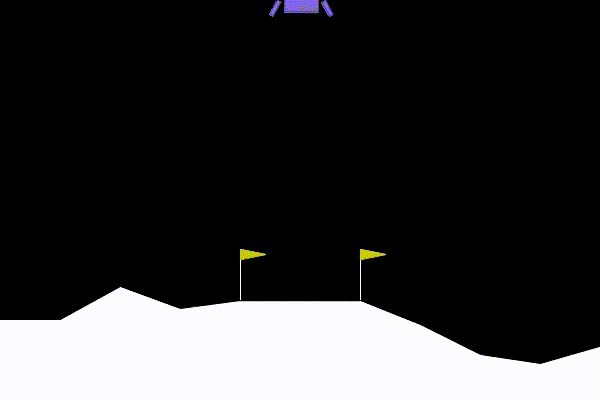

In [1]:
import gymnasium as gym
from gymnasium.wrappers import  RecordVideo
from IPython.display import Image
from moviepy.editor import VideoFileClip

# Initialise the Lunar Lander Environment 
env = gym.make("LunarLander-v3", render_mode="rgb_array")
num_of_episodes = 10
folder="videos/lunarLander_random"


# install env wrapper to record a video
env = RecordVideo(
    env,
    video_folder=folder,                  # Folder
    name_prefix="rand",                   # Video filename prefix
    episode_trigger=lambda x: True        # Record every episode
)

print(f"Running {num_of_episodes} episodes...")
print(f"Saving vides to: {folder}\n")

# Repeat for set number of episodes
for episode_count in range(num_of_episodes):
    # We need to reset the environment before first use
    observation, info = env.reset()

    # initialize total score to zero and step count
    total_score = 0
    num_of_steps = 0
    success_criteria = None

    episode_over = False

    while not episode_over:
        # For now we will use a random agent
        action = env.action_space.sample()

        # Take the random action and recieve information 
        observation, reward, terminated, truncated, info = env.step(action)
        total_score = total_score + reward

        num_of_steps += 1

        episode_over = terminated or truncated

    # The documentation states that a score of 200 or more is a solution
    success_criteria = reward >= 200
    print(f"Episode {episode_count + 1}: {num_of_steps} steps, reward = {total_score}, success: {success_criteria} ")


env.close()
print("\n")

# convert the first mp4 to a gif and show it
first_video = VideoFileClip("videos/lunarLander_random/rand-episode-0.mp4")
#first_video = first_video.resize(0.5)
first_video.write_gif("videos/lunarLander_random/rand-episode-0.gif", program="ffmpeg")

print("\nDisplaying gif from episode 1:")
Image(filename="videos/lunarLander_random/rand-episode-0.gif")

In this script I executed 10 episodes with an agent that performs random actions. For each set I output some simple metrics. We can see the number of steps taken, total reward for the episode, and if it's a valid solution. The gymnasium documentation defines a valid solution as a score of 200 or greater. For each episode I saved a mp4 video in the video/lunarLander_random directory. Finally I displayed the first episode as a gif embedded in this jupyter notebook. 

Visual inspection of the gif from the first epsiode shows the lander immediately crashing. It's score was under the 200 threshold and was a failure. In fact all 10 episodes are considered a failure. Which is expected a random agent can't properly land. 

#### Heuristic Agent

Let's see if we can implement a heuristic agent that can do better. 

We've already defined all of the obervable values in the section above. Let's pull them out of the env so we can closer evaluate them. 




In [2]:

from collections import namedtuple

# Create a named tuple to hold observation data
Observation = namedtuple("Observation", ["x", "y", "x_vel", "y_vel", "angle", "angular_vel", "touch1", "touch2"])

# Initialise the Lunar Lander Environment this time with a limit on episode steps
env = gym.make("LunarLander-v3", max_episode_steps=20)
num_of_episodes = 1


print(f"Running {num_of_episodes} episodes...")

# Repeat for set number of episodes
for episode_count in range(num_of_episodes):
    # We need to reset the environment before first use
    observation, info = env.reset()

    # initialize total score to zero and step count
    total_score = 0
    num_of_steps = 0
    success_criteria = None

    episode_over = False


    while not episode_over:
        # For now we will use a random agent
        action = env.action_space.sample()

        # Take the random action and recieve information 
        observation, reward, terminated, truncated, info = env.step(action)

        # Put observation into the named tuple I created
        obs_tuple = Observation(*observation)
        
        # Print observation for examination
        print(f"observation: {obs_tuple}")

        total_score = total_score + reward

        num_of_steps += 1

        episode_over = terminated or truncated

    # The documentation states that a score of 200 or more is a solution
    success_criteria = reward >= 200
    print(f"Episode {episode_count + 1}: {num_of_steps} steps, reward = {total_score}, success: {success_criteria} ")


env.close()
print("\n")

Running 1 episodes...
observation: Observation(x=np.float32(-0.011677647), y=np.float32(1.4028904), x_vel=np.float32(-0.59530675), y_vel=np.float32(-0.19120343), angle=np.float32(0.014898404), angular_vel=np.float32(0.16326514), touch1=np.float32(0.0), touch2=np.float32(0.0))
observation: Observation(x=np.float32(-0.017548466), y=np.float32(1.3979905), x_vel=np.float32(-0.59533226), y_vel=np.float32(-0.21788213), angle=np.float32(0.023056025), angular_vel=np.float32(0.16316785), touch1=np.float32(0.0), touch2=np.float32(0.0))
observation: Observation(x=np.float32(-0.023322677), y=np.float32(1.3935907), x_vel=np.float32(-0.5862213), y_vel=np.float32(-0.19570746), angle=np.float32(0.031757817), angular_vel=np.float32(0.17405193), touch1=np.float32(0.0), touch2=np.float32(0.0))
observation: Observation(x=np.float32(-0.02920742), y=np.float32(1.3899028), x_vel=np.float32(-0.5968714), y_vel=np.float32(-0.16410814), angle=np.float32(0.040062536), angular_vel=np.float32(0.16611002), touch1=np

Here I ran through 20 states to get an idea of the different observables. I put the observation data into a named tuple. I'm hoping that this will make it easier to decode and use. 

The objective here is to land between the flags. So with this heuristic agent I can adjust left and right if I'm in the wrong area. I can know the position with the x and y values. I think if the body of the lander hits the ground it's a negative reward. So I need to keep track of if I'm landing flat. I can look at the angle values to determin that. Finally the lander will also crash if it's decending too rapidly. I can determin it's fall speed with x_vel. 

So overall, given a state I want to do the following:

- Not between the flags: Adjust course
- Not landing flat: straighten the lander
- decending too rapidly: slow down



Running 10 episodes...
Saving vides to: videos/lunarLander_heuristic

Episode 1: 282 steps, reward = 160.45106713442453, success: False 
Episode 2: 213 steps, reward = 16.03943520141776, success: False 
Episode 3: 394 steps, reward = 214.03342654225463, success: True 
Episode 4: 244 steps, reward = 20.603338139152825, success: False 
Episode 5: 246 steps, reward = -35.28572644718351, success: False 
Episode 6: 217 steps, reward = -25.17892624869944, success: False 
Episode 7: 223 steps, reward = -17.520440851317716, success: False 
Episode 8: 234 steps, reward = 6.570873203983737, success: False 
Episode 9: 214 steps, reward = -33.73558130062759, success: False 
Episode 10: 239 steps, reward = -57.91232956383162, success: False 


MoviePy - Building file  videos/lunarLander_heuristic/heuristic-episode-0.gif
MoviePy - - Generating GIF frames.


MoviePy - - File ready: videos/lunarLander_heuristic/heuristic-episode-0.gif.

Displaying gif from episode 1:


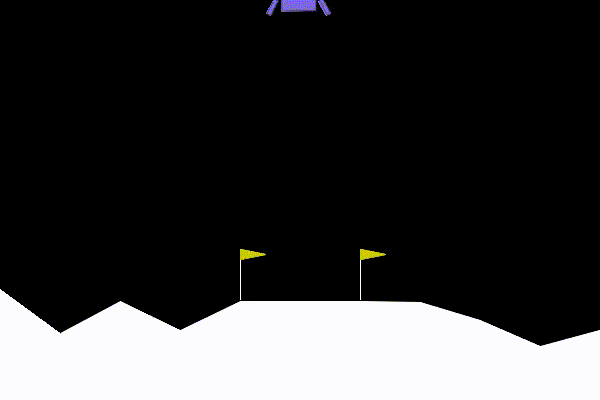

In [3]:

from enum import Enum
import random

# Create a named tuple to hold observation data
Observation = namedtuple("Observation", ["x", "y", "x_vel", "y_vel", "angle", "angular_vel", "touch1", "touch2"])

# Create enum for action space
class LunarAction(Enum):
    IDLE = 0
    FIRE_RIGHT = 1
    FIRE_MAIN = 2
    FIRE_LEFT = 3


def lunar_heuristic(obs):
    obs_tuple = Observation(*obs)

    # Prioity 0: If touch down do nothing
    if obs_tuple.touch1 and obs_tuple.touch2:
        return LunarAction.IDLE.value

    # Priority 1: Control Fall Speed
    if obs_tuple.y_vel < -.3:
        return LunarAction.FIRE_MAIN.value
    
    # Priority 2: Too much tilt
    if obs_tuple.angle > .15:
        return LunarAction.FIRE_LEFT.value
    if obs_tuple.angle < -.15:
        return LunarAction.FIRE_RIGHT.value

    # Priorty 3: Not between flags
    if obs_tuple.x < -.15:
        return LunarAction.FIRE_LEFT.value
    if obs_tuple.x > .15:
        return LunarAction.FIRE_RIGHT.value
    
    
  
    return LunarAction.IDLE.value
    



# Initialise the Lunar Lander Environment 
env = gym.make("LunarLander-v3", render_mode="rgb_array")
num_of_episodes = 10
folder="videos/lunarLander_heuristic"


# install env wrapper to record a video
env = RecordVideo(
    env,
    video_folder=folder,                  # Folder
    name_prefix="heuristic",              # Video filename prefix
    episode_trigger=lambda x: True        # Record every episode
)

print(f"Running {num_of_episodes} episodes...")
print(f"Saving vides to: {folder}\n")

# Repeat for set number of episodes
for episode_count in range(num_of_episodes):
    # We need to reset the environment before first use
    observation, info = env.reset()

    # initialize total score to zero and step count
    total_score = 0
    num_of_steps = 0
    success_criteria = None

    episode_over = False

    while not episode_over:
        # Simple Heuristic agent
        action = lunar_heuristic(observation)

        # Take the random action and recieve information 
        observation, reward, terminated, truncated, info = env.step(action)
        total_score = total_score + reward

        num_of_steps += 1

        episode_over = terminated or truncated

    # The documentation states that a score of 200 or more is a solution
    success_criteria = total_score >= 200
    print(f"Episode {episode_count + 1}: {num_of_steps} steps, reward = {total_score}, success: {success_criteria} ")


env.close()
print("\n")

# convert the first mp4 to a gif and show it
first_video = VideoFileClip("videos/lunarLander_heuristic/heuristic-episode-0.mp4")
#first_video = first_video.resize(0.5)
first_video.write_gif("videos/lunarLander_heuristic/heuristic-episode-0.gif", program="ffmpeg")

print("\nDisplaying gif from episode 1:")
Image(filename="videos/lunarLander_heuristic/heuristic-episode-0.gif")

With the heurisic agent we can see that it's a little smarter. In general the total reward is higher and even occationally (if we are luckly) over the success criteria. Maybe we are just getting a bad sample. Let's run a lot more episodes with the random and heuristic agent and compare. 

In [4]:
# Running my statistic scripts from the scripts directory
# They are slight modifications of the previous scripts.
# I'm not putting them in the notebook so it's not cluttered, but
# if you want to view them they are available.

%run scripts/lunarLander_random_stats.py

# adding space between outputs
print("\n")

%run scripts/lunarLander_heuristic_stats.py

Running 500 random agent episodes...

Stats for 500 random agent episodes:
Average score: -184.72276032432504
Success count: 0
Success rate: 0.0


Running 500 heuristic agent episodes...


Stats for 500 random agent episodes:
Average score: 5.153356543178768
Success count: 43
Success rate: 0.086


The results show that with 500 episodes the heuristic agent is doing much better than the random agent. It's score on average is much higher and it occasionally has success. 

#### DQN Agent

Next I've attempted to implement a DQN Agent. I'm using stable-baseline3 to jump-start this process.

My process is: 

- Run scripts/lunarLander_DQN_train.py
  - To get an initial model started. It runs for 50000 timesteps.
- Run scripts/lunarLander_DQN_train_load.py
  - This model loads the first one and trains for another 50000 timesteps.
  - This script can be run repeatly until training is sufficent.
- At any point the following can be run to diagnose
  - scripts/lunarLander_DQN_model_read.py
    - This file will load a model and read the meta data
    - The most helpful part is it will show the number of timesteps performed
  - scripts/lunarLander_DQN_view.py
    - Sometimes it's useful to see the agent in action so this script will play an episode
  - scripts/lunarLander_DQN_record.py
    - This script will save a recording of the model
   
Additionally the model is saving data into the log directory than can be used by TensorBoard. To view this run the following:

```tensorboard --logdir ./logs/dqn_tensorboard_log```

It will give you a URL. The results of the logs can be viewed there. 

#### DQN Agent in action



In [5]:
# Had to revert to gym for sb3
import gym 
from stable_baselines3 import DQN
import stable_baselines3.common.evaluation as eval

# Init the lunar lander env
# had to revert to v2 for sb3
env = gym.make("LunarLander-v2")


model = DQN("MlpPolicy", 
            env, 
            verbose=0, # Supressing output 
            tensorboard_log="logs/dqn_tensorboard_log")

print(f"Calling learn for 50000 timesteps...")
model.learn(total_timesteps=50_000, log_interval=4)
model.save("models/dqn_lunarlander_v1")
print(f"Learn complete. ")

print(f"Now evaluating policy")
avg_reward, std_reward = eval.evaluate_policy(model, env, n_eval_episodes=25, deterministic=True)

print(f"\nEvaluation has shown: \nAverage Reward: {avg_reward}\nStandard Dev: {std_reward}")

obs = env.reset()

for _ in range(500):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
        obs = env.reset()

env.close()

Calling learn for 50000 timesteps...
Learn complete. 
Now evaluating policy

Evaluation has shown: 
Average Reward: -111.43005011365284
Standard Dev: 49.899681361752606


Here I have run the initial training script for 500000 timesteps. As we can see from the evaluation output the performance is very poor. 

Next I'm going to learn and train this model in 50000 timestep increments. It take a couple of rounds for it to get interesting. 

In [8]:
# Had to revert to gym for sb3
import gym 
from stable_baselines3 import DQN
import stable_baselines3.common.evaluation as eval
import shutil


time_steps_to_train = 50_000

# Init the lunar lander env
# had to revert to v2 for sb3
env = gym.make("LunarLander-v2")


# load saved model
model = DQN.load("models/dqn_lunarlander_v1", env=env)

time_steps_so_far = model.num_timesteps


model.learn(total_timesteps=time_steps_so_far + time_steps_to_train, log_interval=4)
# save with number of timesteps in name
model.save(f"models/dqn_lunarlander_v1_{time_steps_so_far + time_steps_to_train}")

# copy to original name that way I have a checkpoint
shutil.copy2(f"models/dqn_lunarlander_v1_{time_steps_so_far + time_steps_to_train}.zip", "models/dqn_lunarlander_v1.zip" )


avg_reward, std_reward = eval.evaluate_policy(model, env, n_eval_episodes=25, deterministic=True)

print(f"\nEvaluation has shown: \nAverage Reward: {avg_reward}\nStandard Dev: {std_reward}")




Evaluation has shown: 
Average Reward: -118.88967864100108
Standard Dev: 34.15872022754175


In [11]:
# Had to revert to gym for sb3
import gym 
from stable_baselines3 import DQN
import stable_baselines3.common.evaluation as eval
import shutil


# Init the lunar lander env
# had to revert to v2 for sb3
env = gym.make("LunarLander-v2")
model_file_name = "models/dqn_lunarlander_v1_save"

# load saved model
model = DQN.load(model_file_name, env=env)

# print model meta data
print()
print(f"---- Meta Data for model: {model_file_name} ----")
print(f"Algorithm: {model.__class__.__name__}")
print(f"Policy: {model.policy.__class__.__name__}")
print(f"Obs Space: {model.observation_space}")
print(f"Action Space: {model.action_space}")
print(f"Device: {model.device}")
print(f"-- Hyperparameters:")
print(f"Learning Rate: {model.learning_rate}")
print(f"Gamma: {model.gamma}")
print(f"Batch size: {model.batch_size}")
print(f"Buffer size: {model.buffer_size}")
print(f"-- Training Done:")
print(f"Timesteps: {model.num_timesteps}")
print(f"Episodes: {model._episode_num}")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

---- Meta Data for model: models/dqn_lunarlander_v1_save ----
Algorithm: DQN
Policy: DQNPolicy
Obs Space: Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)
Action Space: Discrete(4)
Device: cpu
-- Hyperparameters:
Learning Rate: 0.0001
Gamma: 0.99
Batch size: 32
Buffer size: 1000000
-- Training Done:
Timesteps: 300000
Episodes: 797


I've trained a model for 300k timesteps and have renamed it to dqn_lunarlander_v1_save to keep my progress. It's taking longer each time to do training. 


In [12]:
# Had to revert to gym for sb3
import gym 
from stable_baselines3 import DQN
import stable_baselines3.common.evaluation as eval
from gym.wrappers import RecordVideo
from moviepy.editor import VideoFileClip
from IPython.display import Video



# Init the lunar lander env
# had to revert to v2 for sb3
env = gym.make("LunarLander-v2")

num_of_episodes = 1
folder="videos/lunarLander_DQN"

# install env wrapper to record a video
env = RecordVideo(
    env,
    video_folder=folder,                  # Folder
    name_prefix="DQN_v1",              # Video filename prefix
    episode_trigger=lambda x: True        # Record every episode
)

print(f"Running {num_of_episodes} episodes...")
print(f"Saving vides to: {folder}\n")

# load saved model
model = DQN.load("models/dqn_lunarlander_v1_save", env=env)


# Repeat for set number of episodes
for episode_count in range(num_of_episodes):
    # We need to reset the environment before first use
    obs = env.reset()

    # initialize total score to zero and step count
    total_score = 0
    num_of_steps = 0
    success_criteria = None

    episode_over = False

    while not episode_over:
        # DQN agent
        action, _states = model.predict(obs, deterministic=True)

        # Take model action and recieve information 
        obs, reward, done, info = env.step(action)
        total_score = total_score + reward
        episode_over = done
        num_of_steps += 1

        #env.render()


    # The documentation states that a score of 200 or more is a solution
    success_criteria = total_score >= 200
    print(f"Episode {episode_count + 1}: {num_of_steps} steps, reward = {total_score}, success: {success_criteria} ")

env.close()
print("\n")

# convert the first mp4 to a gif and show it
#first_video = VideoFileClip("videos/lunarLander_DQN/DQN_v1-episode-0.mp4")
#first_video = first_video.resize(0.5)
#first_video = first_video.subclip(0, 10)
#first_video.write_gif("videos/lunarLander_hDQN/DQN_v1-episode-0.gif", program="ffmpeg", fps=15)

print("\nDisplaying video from episode 1:")
Video(filename="videos/lunarLander_DQN/DQN_v1-episode-0.mp4", embed=True)

Running 1 episodes...
Saving vides to: videos/lunarLander_DQN

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode 1: 1000 steps, reward = -17.60578120928943, success: False 



Displaying video from episode 1:


Here we can see the results of the 300k timestep training. The lander is able to maintain a hover and no longer crash. However it does not commit to the ultimate goal of actually landing. Without landing it's not reaching the reward criteria of 200 to be concidered a success. 

